In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import polars as pl
import utils
from scipy.optimize import least_squares, curve_fit, minimize
import numpy as np
import os
from tqdm import tqdm
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from DataLoader import DataLoader
import datetime as dt
import joblib as joblib
import Calibration as calibration
from typing import Tuple

import warnings
warnings.filterwarnings("ignore")

In [3]:
start, end = "20060224", "20230831"
loader = DataLoader("./data", "csv")
df = loader.load_dates(start, end).sort('Date')[:, 1:]

In [4]:
res = pl.read_parquet('params_20060224_20230831.parquet')
res.columns = res.columns[:-1] + ['date']
res

H,eta,err_code,date
f64,f64,f64,datetime[ns]
0.060878,1.240324,0.0,2006-02-24 00:00:00
0.001504,6.514187,0.0,2006-02-27 00:00:00
0.103098,1.246271,0.0,2006-02-28 00:00:00
0.218843,1.309456,0.0,2006-03-01 00:00:00
0.000359,16.490253,0.0,2006-03-02 00:00:00
…,…,…,…
0.003983,12.433389,0.0,2023-08-24 00:00:00
0.021462,5.520464,0.0,2023-08-25 00:00:00
0.029094,4.848911,0.0,2023-08-28 00:00:00


In [5]:
dates = res.filter(pl.col('err_code')==1)['date']

In [6]:
failed = df.filter(pl.col('Date').is_in(dates))
failed

Expiry,Texp,Strike,Bid,Ask,Fwd,CallMid,Date
i64,f64,f64,f64,f64,f64,f64,datetime[ns]
20060719,0.093151,12.5,0.69134,0.947509,16.293825,4.0,2006-06-15 00:00:00
20060719,0.093151,15.0,0.794019,0.96067,16.293825,2.375,2006-06-15 00:00:00
20060719,0.093151,17.5,0.871538,1.073819,16.293825,1.45,2006-06-15 00:00:00
20060719,0.093151,20.0,1.016273,1.128372,16.293825,0.95,2006-06-15 00:00:00
20060719,0.093151,22.5,1.049316,1.217591,16.293825,0.625,2006-06-15 00:00:00
…,…,…,…,…,…,…,…
20240417,0.673511,140.0,1.005966,1.048042,20.723892,0.171824,2023-08-15 00:00:00
20240417,0.673511,150.0,1.013574,1.060234,20.723892,0.150997,2023-08-15 00:00:00
20240417,0.673511,160.0,1.027859,1.068587,20.723892,0.135376,2023-08-15 00:00:00


In [7]:
day1 = failed['Date'].unique()[0]

In [8]:
failed.filter(pl.col('Date') == day1)

Expiry,Texp,Strike,Bid,Ask,Fwd,CallMid,Date
i64,f64,f64,f64,f64,f64,f64,datetime[ns]
20060719,0.093151,12.5,0.69134,0.947509,16.293825,4.0,2006-06-15 00:00:00
20060719,0.093151,15.0,0.794019,0.96067,16.293825,2.375,2006-06-15 00:00:00
20060719,0.093151,17.5,0.871538,1.073819,16.293825,1.45,2006-06-15 00:00:00
20060719,0.093151,20.0,1.016273,1.128372,16.293825,0.95,2006-06-15 00:00:00
20060719,0.093151,22.5,1.049316,1.217591,16.293825,0.625,2006-06-15 00:00:00
…,…,…,…,…,…,…,…
20070214,0.668607,27.5,0.59767,0.652905,17.273379,1.075,2006-06-15 00:00:00
20070214,0.668607,30.0,0.622781,0.682669,17.273379,0.925,2006-06-15 00:00:00
20070516,0.917808,15.0,0.341941,0.413542,17.267955,3.65,2006-06-15 00:00:00


In [9]:
## Debug

In [10]:
# Parameters
H = utils.Hurst(0.07)
eta = 1.9
volvol = eta * np.sqrt(H.h2) / (utils.c_h(H) * 2)

def calibration_jim(texps, h, _eta):
    hurst = utils.Hurst(h)
    sigma_model = np.array([
        calibration.sigma_jim(texp, _eta, hurst) for texp in texps
    ])
    return sigma_model


def calibration_h_jim(texps, h):
    hurst = utils.Hurst(h)
    sigma_model = np.array([
        calibration.sigma_jim(texp, eta, hurst) for texp in texps
    ])
    return sigma_model

In [11]:
dd = failed.filter(pl.col('Date') == day1).to_pandas()
dd

,Expiry,Texp,Strike,Bid,Ask,Fwd,CallMid,Date
0,20060719,0.093151,12.5,0.691340,0.947509,16.293825,4.000,2006-06-15
1,20060719,0.093151,15.0,0.794019,0.960670,16.293825,2.375,2006-06-15
2,20060719,0.093151,17.5,0.871538,1.073819,16.293825,1.450,2006-06-15
3,20060719,0.093151,20.0,1.016273,1.128372,16.293825,0.950,2006-06-15
4,20060719,0.093151,22.5,1.049316,1.217591,16.293825,0.625,2006-06-15
5,20060719,0.093151,25.0,1.168714,1.324787,16.293825,0.500,2006-06-15
6,20060719,0.093151,27.5,1.184780,1.420553,16.293825,0.375,2006-06-15
7,20060719,0.093151,30.0,1.186542,1.430549,16.293825,0.250,2006-06-15
8,20060816,0.169863,10.0,0.773752,0.848219,16.512433,6.600,2006-06-15
9,20060816,0.169863,12.5,0.756696,0.907254,16.512433,4.600,2006-06-15


In [12]:
dd.groupby('Texp')['Texp'].count()

Texp
0.093151    8
0.169863    9
0.419292    9
0.668607    8
0.917808    3
Name: Texp, dtype: int64

In [13]:
exp_dates = dd['Expiry'].unique()
exp_dates

array([20060719, 20060816, 20061115, 20070214, 20070516])

In [14]:
sigmas = np.array([
    calibration.sigma_market(dd, exp) for exp in exp_dates
])
sigmas

array([0.58775426, 0.83664129, 0.93914396, 1.1543767 , 1.12689335])

In [15]:
texp_array = dd['Texp'].unique()

In [16]:
obj = lambda x: 1000*np.sum((calibration_jim(texp_array, x[0], x[1]) - sigmas)**2)
options = {'eps': 1e-7}
opt = minimize( 
    obj, np.array([0.07, eta]),
    method='L-BFGS-B',
    bounds=((0., 1.), (1., None)),
    options=options
)


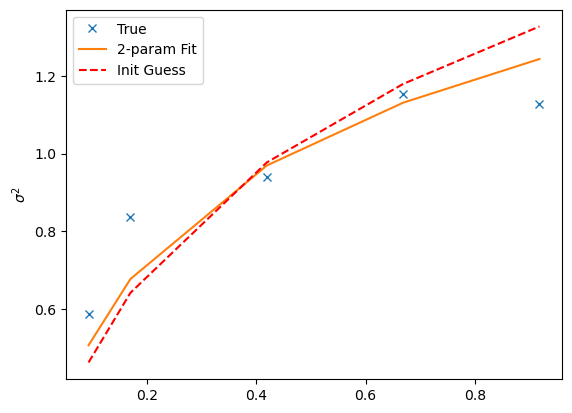

In [17]:
sigma_joint = calibration_jim(texp_array, *opt.x)
sigma_hat_0 = calibration_jim(texp_array, H.h, eta)
plt.plot(texp_array, sigmas, lw=0, marker='x', label='True', color='C0')
plt.plot(texp_array, sigma_joint, label='2-param Fit', color='C1')
plt.plot(texp_array, sigma_hat_0, color='red', ls='--', label='Init Guess')
plt.ylabel(r"$\sigma^2$")
plt.legend()
plt.show()

In [18]:
opt

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 47.36449517662196
        x: [ 3.560e-04  2.292e+01]
      nit: 166
      jac: [ 4.844e+02 -1.102e-01]
     nfev: 1104
     njev: 368
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [19]:
opt.x

array([3.56046455e-04, 2.29194440e+01])

In [41]:
df

Expiry,Texp,Strike,Bid,Ask,Fwd,CallMid,Date
i64,f64,f64,f64,f64,f64,f64,datetime[ns]
20060322,0.071233,12.5,0.397999,0.751937,12.251797,0.625,2006-02-24 00:00:00
20060322,0.071233,15.0,0.500455,0.667055,12.251797,0.1,2006-02-24 00:00:00
20060419,0.147831,12.5,0.346001,0.533366,12.99698,1.3,2006-02-24 00:00:00
20060419,0.147831,15.0,0.46873,0.758272,12.99698,0.55,2006-02-24 00:00:00
20060419,0.147831,17.5,0.590799,1.052294,12.99698,0.475,2006-02-24 00:00:00
…,…,…,…,…,…,…,…
20240522,0.728268,110.0,0.899486,0.960186,20.297357,0.213034,2023-08-30 00:00:00
20240522,0.728268,120.0,0.917649,0.977613,20.297357,0.187055,2023-08-30 00:00:00
20240522,0.728268,130.0,0.930241,0.996458,20.297357,0.166271,2023-08-30 00:00:00


In [48]:
opt_count = failed.group_by(['Date', 'Texp'], maintain_order=True).len().group_by('Date').min()
opt_count

Date,Texp,len
datetime[ns],f64,u32
2006-06-15 00:00:00,0.093151,3
2006-12-18 00:00:00,0.005479,1
2007-03-07 00:00:00,0.038242,11
2007-03-21 00:00:00,0.076712,11
2007-03-26 00:00:00,0.063014,12
…,…,…
2022-10-11 00:00:00,0.002738,7
2023-03-21 00:00:00,0.002738,20
2023-05-23 00:00:00,0.002738,5


In [59]:
opt_count.describe()

statistic,Date,Texp,len
str,str,f64,f64
"""count""","""107""",107.0,107.0
"""null_count""","""0""",0.0,0.0
"""mean""","""2016-09-27 12:06:43.738317""",0.027997,14.672897
"""std""",null,0.028167,7.070769
"""min""","""2006-06-15 00:00:00""",0.002738,1.0
"""25%""","""2012-12-06 00:00:00""",0.005476,9.0
"""50%""","""2018-02-20 00:00:00""",0.016427,15.0
"""75%""","""2021-06-11 00:00:00""",0.043836,20.0
"""max""","""2023-08-15 00:00:00""",0.095825,31.0


In [61]:
df.group_by(['Date', 'Texp'], maintain_order=True).len().group_by('Date').min().describe()

statistic,Date,Texp,len
str,str,f64,f64
"""count""","""4409""",4409.0,4409.0
"""null_count""","""0""",0.0,0.0
"""mean""","""2014-11-26 15:12:32.007258""",0.029657,12.853935
"""std""",null,0.025151,6.537063
"""min""","""2006-02-24 00:00:00""",0.002738,1.0
"""25%""","""2010-07-13 00:00:00""",0.013689,8.0
"""50%""","""2014-11-25 00:00:00""",0.019165,12.0
"""75%""","""2019-04-15 00:00:00""",0.043836,18.0
"""max""","""2023-08-30 00:00:00""",0.09863,37.0


In [ ]:
def recalibrate_with_small_step(dd) -> Tuple[np.array, bool]:
    _df = failed.filter(pl.col('Date') == dd).to_pandas()
    # address expirations with single obs
    single_texp = _df.groupby('Texp')['Texp'].count()
    single_texp = set(single_texp[single_texp == 1].index)
    _df = _df[~_df['Texp'].isin(single_texp)]

    exp_dates = _df['Expiry'].unique()
    texp_array = _df['Texp'].unique()

    sigmas = np.array([calibration.sigma_market(_df, exp) for exp in exp_dates])
    obj = lambda x: 1000 * np.sum((calibration_jim(texp_array, x[0], x[1]) - sigmas)**2)
    options = {'eps': 1e-7}
    opt = minimize( 
        obj, np.array([0.07, eta]),
        method='L-BFGS-B',
        bounds=((0., 1.), (1., None)),
        options=options
    )

    if opt.success:
        return (opt.x, True)
    else:
        return (np.empty(2) * np.nan, False)

In [21]:
out = joblib.Parallel(n_jobs=-1, verbose=5)(
    joblib.delayed(recalibrate_with_small_step)(dd) for dd in dates.to_list()
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.0s
/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  callIntegral, _ = quad(
/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position o

In [22]:
sum(x[1] for x in out) / len(out)

0.8785046728971962

In [23]:
new_params = pd.DataFrame(
    {dd: x[0] for dd, x in zip(dates.to_list(), out)}
).set_axis(['H', 'eta']).T

new_params.index.name = 'Date'

In [24]:
new_params.isna().sum()

H      13
eta    13
dtype: int64

In [25]:
new_params.describe()

,H,eta
count,94.000000,94.000000
mean,0.000679,25.444791
std,0.000943,8.780562
min,0.000229,7.324413
25%,0.000372,18.448881
50%,0.000470,24.264088
75%,0.000689,32.655540
max,0.009102,46.345395


In [32]:
params = pd.read_parquet('params_20060224_20230831.parquet')#.rename({'__index_level_0__': 'Date'})

In [34]:
params.groupby('err_code').describe()

H                                                              \
           count      mean       std       min       25%       50%       75%   
err_code                                                                       
0.0       4302.0  0.049533  0.075763  0.000045  0.000208  0.001345  0.078974   
1.0        107.0  0.163868  0.073842  0.031754  0.087033  0.191866  0.224819   

                       eta                                           \
               max   count       mean       std       min       25%   
err_code                                                              
0.0       1.000000  4302.0  20.030346  20.55648  1.020791  2.222176   
1.0       0.386553     0.0        NaN       NaN       NaN       NaN   

                                          
                50%        75%       max  
err_code                                  
0.0       11.690711  34.274953  134.6066  
1.0             NaN        NaN       NaN

In [27]:
params.loc[new_params.index, ['H', 'eta']] = new_params

In [31]:
params.describe()

,H,eta,err_code
count,4409.000000,4302.000000,4409.000000
mean,0.052308,20.030346,0.024269
std,0.077726,20.556480,0.153899
min,0.000045,1.020791,0.000000
25%,0.000212,2.222176,0.000000
50%,0.002851,11.690711,0.000000
75%,0.084064,34.274953,0.000000
max,1.000000,134.606600,1.000000


In [35]:
import seaborn as sns

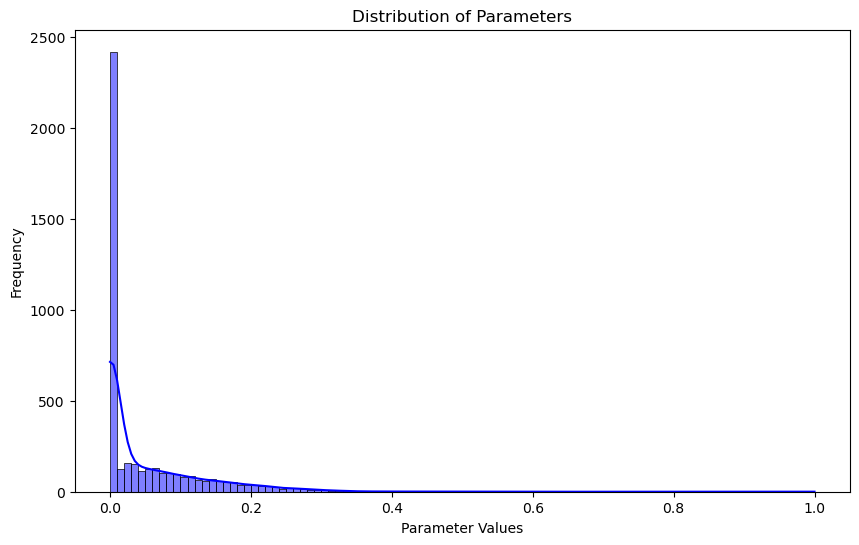

In [38]:
# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(params.H, kde=True, color='blue', binwidth=0.01)
plt.title('Distribution of Parameters')
plt.xlabel('Parameter Values')
plt.ylabel('Frequency')
plt.show()

<Axes: ylabel='Density'>

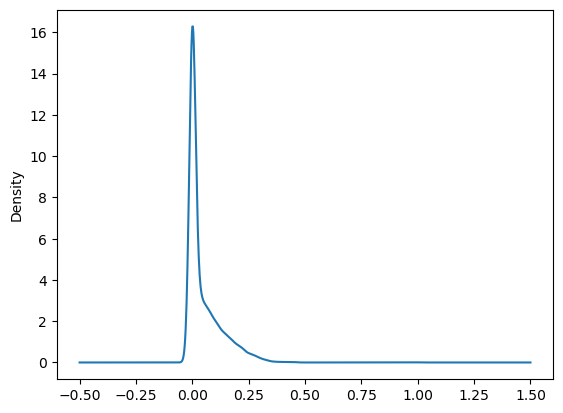

In [33]:
params.H.plot(kind='kde')

In [72]:
params.loc[new_params.index]

,H,eta,err_code
Date,,,
2006-06-15,0.000395,21.757417,1.0
2006-12-18,0.000405,17.849454,1.0
2007-03-07,0.000853,12.936098,1.0
2007-03-21,0.000447,18.063065,1.0
2007-03-26,0.000521,16.722682,1.0
...,...,...,...
2022-10-11,NaN,NaN,1.0
2023-03-21,0.000685,27.442232,1.0
2023-05-23,0.000618,28.992731,1.0


In [28]:
new_params.loc[new_params['H'].isna()]

,H,eta
Date,,
2011-06-14,NaN,NaN
2012-08-30,NaN,NaN
2014-06-20,NaN,NaN
2014-08-25,NaN,NaN
2016-11-10,NaN,NaN
2017-04-17,NaN,NaN
2018-03-05,NaN,NaN
2018-03-22,NaN,NaN
2018-06-19,NaN,NaN


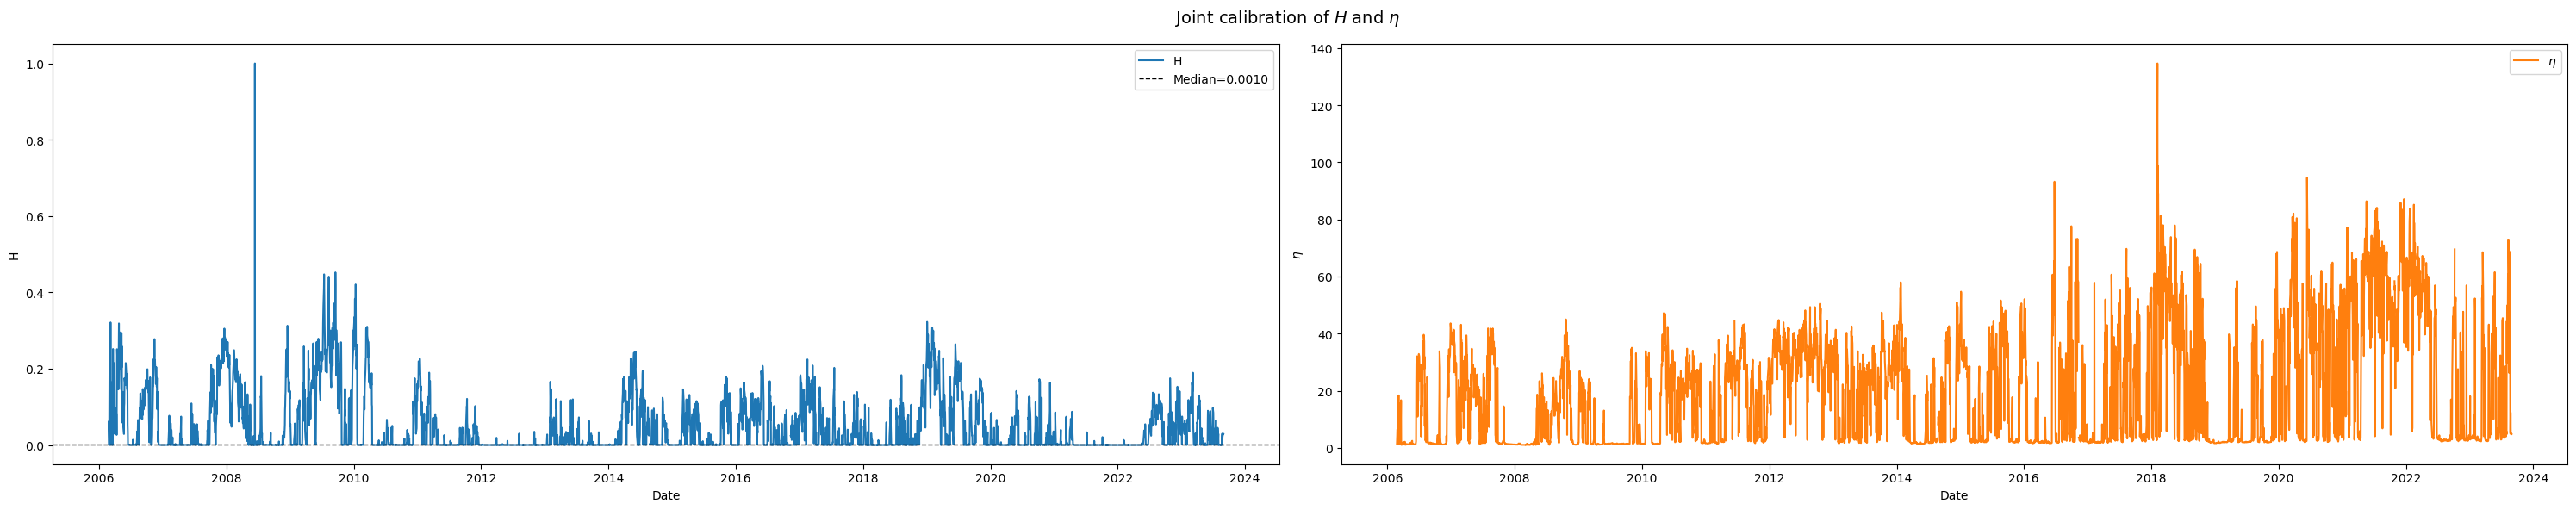

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(30, 6))
fig.suptitle(r"Joint calibration of $H$ and $\eta$", fontsize=14)

axs[0].plot(params['H'], label='H', color='C0')
axs[0].axhline(params['H'].median(), ls='--', color='black', lw=1, label=f'Median={params["H"].median():.4f}')
axs[1].plot(params['eta'], label=r'$\eta$', color='C1')
axs[0].set_ylabel("H"); axs[1].set_ylabel(r"$\eta$")
for ax in axs:
    ax.legend()
    ax.set_xlabel("Date")

fig.tight_layout()
plt.savefig(f"./Plots/calibrated_params_{start}_{end}.png")
plt.show()

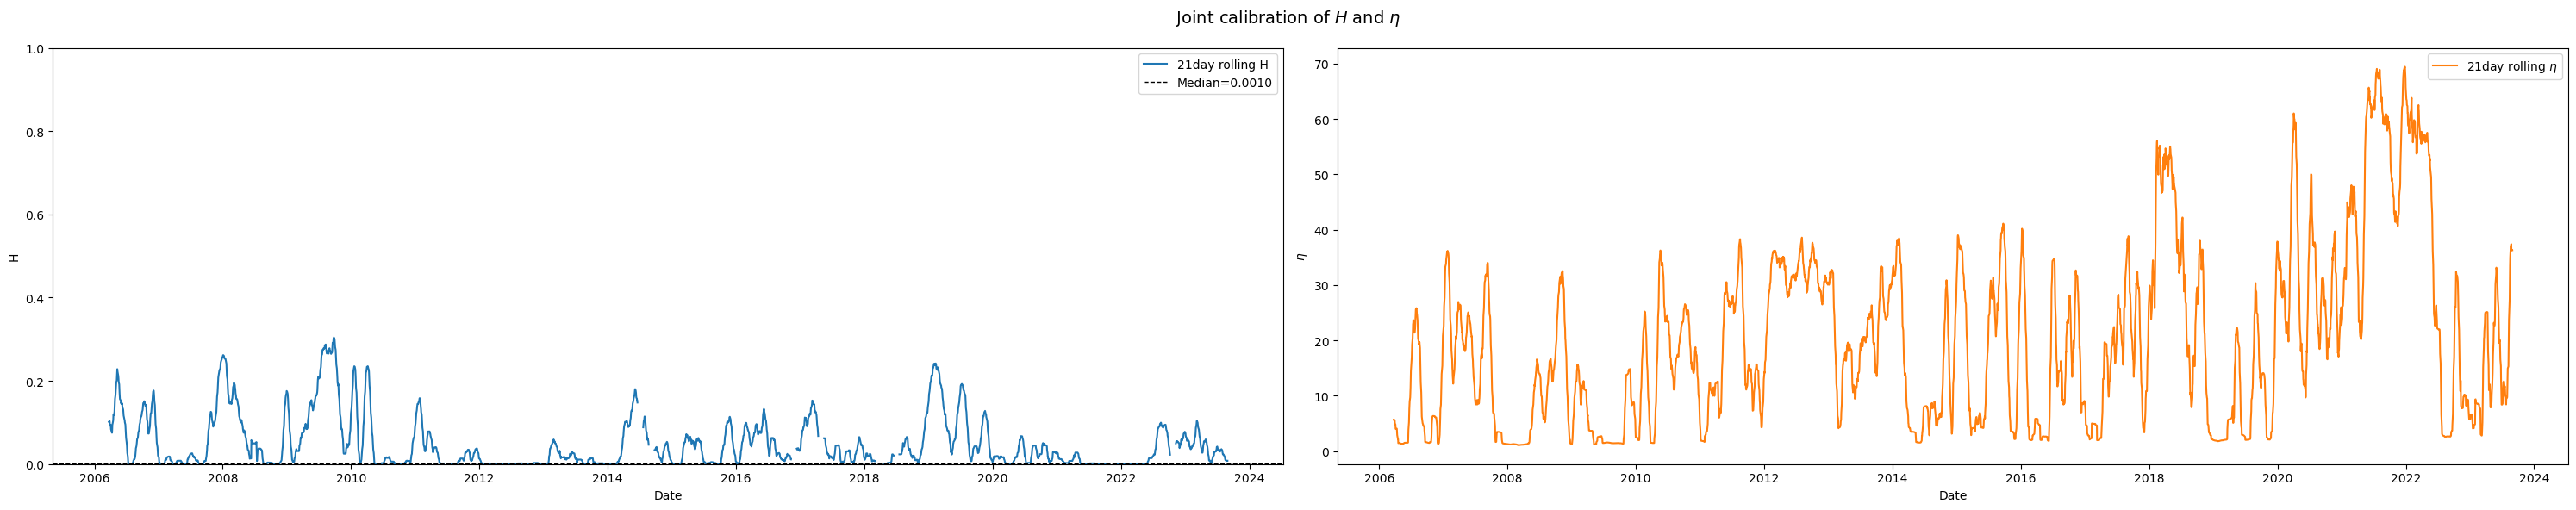

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(30, 6))
fig.suptitle(r"Joint calibration of $H$ and $\eta$", fontsize=14)

axs[0].plot(params['H'].rolling(21).mean(), label='21day rolling H', color='C0')
axs[0].axhline(params['H'].median(), ls='--', color='black', lw=1, label=f'Median={params["H"].median():.4f}')
axs[1].plot(params['eta'].fillna(1.9).rolling(21).mean(), label=r'21day rolling $\eta$', color='C1')
axs[0].set_ylabel("H"); axs[1].set_ylabel(r"$\eta$")
axs[0].set_ylim(0, 1)
for ax in axs:
    ax.legend()
    ax.set_xlabel("Date")

fig.tight_layout()
plt.show()

In [79]:
params.to_parquet('params_20060224_20230831_fixed.parquet')

In [93]:
old_params = params[~params.index.isin(dates)].reset_index()

In [102]:
new_params[['H']].reset_index().rename(columns={'Date': 'index'})

,index,H
0,2006-06-15,0.000395
1,2006-12-18,0.000405
2,2007-03-07,0.000853
3,2007-03-21,0.000447
4,2007-03-26,0.000521
...,...,...
102,2022-10-11,NaN
103,2023-03-21,0.000685
104,2023-05-23,0.000618
105,2023-05-26,0.000651


In [103]:
old_params

,index,H,eta,err_code
0,2006-02-24,0.060878,1.240324,0.0
1,2006-02-27,0.001504,6.514187,0.0
2,2006-02-28,0.103098,1.246271,0.0
3,2006-03-01,0.218843,1.309456,0.0
4,2006-03-02,0.000359,16.490253,0.0
...,...,...,...,...
4297,2023-08-24,0.003983,12.433389,0.0
4298,2023-08-25,0.021462,5.520464,0.0
4299,2023-08-28,0.029094,4.848911,0.0
4300,2023-08-29,0.028095,4.936410,0.0


In [114]:
h = old_params[['index', 'H']].merge(new_params[['H']].reset_index().rename(columns={'Date': 'index'}), on='index', how='outer').set_index('index')
e = old_params[['index', 'eta']].merge(new_params[['eta']].reset_index().rename(columns={'Date': 'index'}), on='index', how='outer').set_index('index')

In [1]:
h

NameError: name 'h' is not defined

In [117]:
h = h.set_axis(['H_base', 'H_new'], axis=1)
e = e.set_axis(['eta_base', 'eta_new'], axis=1)

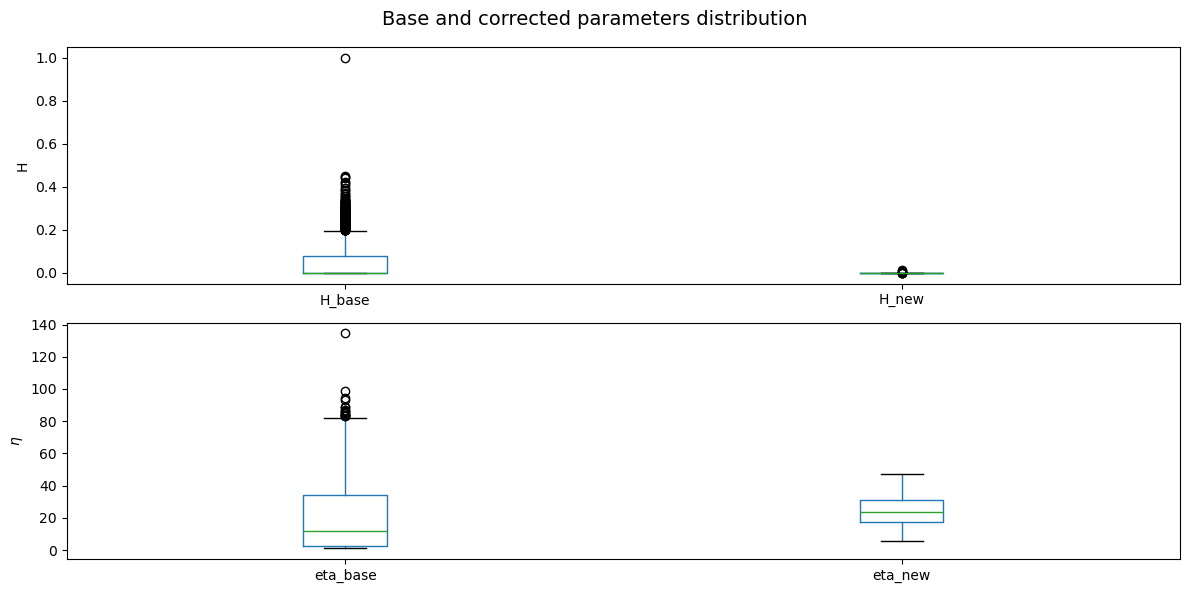

In [118]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
fig.suptitle(r"Base and corrected parameters distribution", fontsize=14)

h.boxplot(ax=axs[0])
e.boxplot(ax=axs[1])
axs[0].set_ylabel("H"); axs[1].set_ylabel(r"$\eta$")
for ax in axs:
    ax.grid(False)

fig.tight_layout()
plt.show()

In [84]:
params[~params.index.isin(dates)].describe().iloc[3:, :-1]

,H,eta
min,0.000045,1.020791
25%,0.000208,2.222176
50%,0.001345,11.690711
75%,0.078974,34.274953
max,1.000000,134.606600


In [85]:
new_params.describe().iloc[3:]

,H,eta
min,0.000224,5.750263
25%,0.000369,17.416416
50%,0.000521,23.505003
75%,0.000796,30.870886
max,0.013430,46.941074
